<a href="https://colab.research.google.com/github/Bryan-Az/Neurobytes/blob/notebooks/mlops/notebooks/users_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of the Synthetic User Preferences


## Spotify Million Song Dataset (Via Kaggle)
This synthetic dataset was generated with the Kaggle 'Spotify Million Song' dataset.

The original data contains the features:

- 'artist': The name of the artist
- 'song': The name of the song
- 'text': The song lyrics
- 'link': The link to the song via spotify api

A sample of 10,000 rows was selected from this dataset to calculate synthetic user preferences, as the original dataset is very large. The document-term matrix was calculated, where each song is a document and the words in the lyrics are the terms.

## Synthetic User Preference Data

The cosin similarity was calculated, representing the similarity between from songs-to-songs by their lyrics. This data was then used to calculate synthetic user data by sampling a 'starter' song for each user, and then using the top 3 similar songs to the original song as their sample user preferences. Then, the following two columns were added to a new user preferences dataset:

- 'songID': a many-to-one foreign key to the original song dataset.
- 'userID': a many-to-one userID index.

Our synthetic user prefernce generator selects n_starter songs and then uses cosin similarity to select n further top-n similar songs for the original n_starter song, such that each user will have a variety of 'tastees'.

 For example, each 'song cluster' sample (n_starter) includes self (original song) with similarity of 1, then included n similar songs (starter song + n similar songs).
  
  To calculate the size, for example, n = 3, songs_per_user = 50, num_users=1000
  returns: num_users * (n + 1) * (songs_per_user) = ~200,000 preferences (variable as n_starter is random value between 40-50).



In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

In [2]:
! pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
users_lyrics_only_glink = 'https://drive.google.com/file/d/1fw3kszKGlaz4x6oMgCMNmY_s3ejwdGxT/view?usp=drive_link'
lyrics_only_filename = 'user_preferences_lyrics_only.csv'

In [6]:
users_artist_lyrics_glink = 'https://drive.google.com/file/d/1v1aXLG-PoTR6-UqJGQml-heLoPz8Lu-R/view?usp=drive_link'
users_artist_lyrics_filename = 'user_preferences_artist_lyrics.csv'

In [35]:
users_song_artist_lyrics_glink = 'https://drive.google.com/file/d/1_XwU8HWCRZVJV8qohSnzgqxfflh_STnM/view?usp=drive_link'
users_song_artist_lyrics_filename = 'user_preferences_song_artist_lyrics.csv'

In [7]:
def get_link_content(link, name):
  file_id = link.split('/')[-2]
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)

In [36]:
get_link_content(users_lyrics_only_glink, lyrics_only_filename)
get_link_content(users_artist_lyrics_glink, users_artist_lyrics_filename)
get_link_content(users_song_artist_lyrics_glink, users_song_artist_lyrics_filename)

In [9]:
user_lyrics_only_preferences = pd.read_csv(lyrics_only_filename, index_col=0).sort_values(by='userID').loc[:, ['userID','songID', 'artist', 'song', 'text', 'link']]

In [10]:
user_preferences_artist_lyrics = pd.read_csv(users_artist_lyrics_filename, index_col=0).sort_values(by='userID').loc[:, ['userID','songID', 'artist', 'song', 'text', 'link']]

In [37]:
user_preferences_song_artist_lyrics = pd.read_csv(users_song_artist_lyrics_filename, index_col=0).sort_values(by='userID').loc[:, ['userID','songID', 'artist', 'song', 'text', 'link']]

In [38]:
print(user_lyrics_only_preferences.shape)
print(user_preferences_artist_lyrics.shape)
print(user_preferences_song_artist_lyrics.shape)

(178340, 6)
(178136, 6)
(177780, 6)


# Identifying the 'Favorite'/'Most Listened' to Artist's

As the algorithm to generate synthetic user preferences assigned users clusters of songs that had fairly similar cosin similarity (at random, based on samples of the main dataset) using the lyric information, every user should have a different set of artists and a different ranking of artists by # songs within the user preferences dataset.

In [12]:
preference_size_distribution_lyrics_only = user_lyrics_only_preferences.groupby('userID').count().describe()['songID'] # the general distribution of # of songs per user, for 1000 users
preference_size_distribution_lyrics_only

count    1000.000000
mean      178.340000
std        11.171804
min       160.000000
25%       168.000000
50%       180.000000
75%       188.000000
max       196.000000
Name: songID, dtype: float64

In [39]:
preference_size_distribution_artist_lyrics = user_preferences_artist_lyrics.groupby('userID').count().describe()['songID'] # the general distribution of # of songs per user, for 1000 users
preference_size_distribution_artist_lyrics

count    1000.000000
mean      178.136000
std        11.492675
min       160.000000
25%       168.000000
50%       176.000000
75%       188.000000
max       196.000000
Name: songID, dtype: float64

In [40]:
preference_size_distribution_song_artist_lyrics = user_preferences_song_artist_lyrics.groupby('userID').count().describe()['songID'] # the general distribution of # of songs per user, for 1000 users
preference_size_distribution_song_artist_lyrics

count    1000.00000
mean      177.78000
std        11.59267
min       160.00000
25%       168.00000
50%       176.00000
75%       188.00000
max       196.00000
Name: songID, dtype: float64

In [14]:
sample_user_lyrics_only = user_lyrics_only_preferences.where(user_lyrics_only_preferences['userID'] == user_lyrics_only_preferences['userID'].sample(1).iloc[0]).dropna() # a sample user

In [15]:
sample_user_lyrics_only.groupby('artist').count().mean(axis=1).sort_values(ascending=False).head(10) # top 10 artists

artist
Iron Maiden      6.0
Bee Gees         3.0
Puff Daddy       3.0
Pretenders       3.0
Tracy Chapman    3.0
Sting            2.0
Fabolous         2.0
Green Day        2.0
Howard Jones     2.0
Alabama          2.0
dtype: float64

In [16]:
sample_user_preferences_artist_lyrics = user_preferences_artist_lyrics.where(user_preferences_artist_lyrics['userID'] == user_preferences_artist_lyrics['userID'].sample(1).iloc[0]).dropna()

In [17]:
sample_user_preferences_artist_lyrics.groupby('artist').count().mean(axis=1).sort_values(ascending=False).head(10) # top 10 artists

artist
Waylon Jennings       4.0
Norah Jones           4.0
One Direction         4.0
Modern Talking        4.0
Dave Matthews Band    3.0
Kelly Clarkson        3.0
Mariah Carey          3.0
Dean Martin           2.0
Stevie Wonder         2.0
Elvis Costello        2.0
dtype: float64

In [41]:
sample_user_preferences_song_artist_lyrics = user_preferences_song_artist_lyrics.where(user_preferences_song_artist_lyrics['userID'] == user_preferences_song_artist_lyrics['userID'].sample(1).iloc[0]).dropna()

In [42]:
sample_user_preferences_song_artist_lyrics.groupby('artist').count().mean(axis=1).sort_values(ascending=False).head(10) # top 10 artists

artist
Waylon Jennings     5.0
Wiz Khalifa         4.0
Glen Campbell       4.0
Wishbone Ash        3.0
Chaka Khan          3.0
Morrissey           3.0
Who                 3.0
Erik Santos         3.0
Barbra Streisand    3.0
Rainbow             3.0
dtype: float64

## Histograms of Top Artist's by Recommendation Type

Given any sample user, it seems that identifying their 'favorite' artist would be a tough choice to make. The majority of artists within these sample user's preferences make a low number of appearances, and any artist with more than 3 appearances is very rare.

My theory is that given that 'artist' name, or 'song' name was not originally used as input to the cosin similarity algorithm, it could be ignoring the artist's identities when making recommendations, and user preferences do not seem to skew to any particular artist.

By visualizing the same distribution - this time using the entire user preferences dataset - we can see that most artists make an appearance within a user's library 1-3 times, with a small right tail skewing the distribution towards 4-8 appearances.

Perhaps including the artist's name or the song name into the document-term matrix before generating the synthetic user preferences would allow for a more concentrated selection of choices that might mimic how individual user's tend to favor entire albums or playlists centered around a particular artist.

### Histogram of Artist Frequencies in Lyric Only Preference Data

<Axes: >

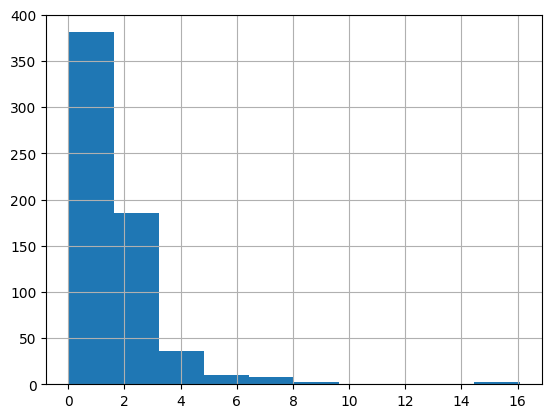

In [19]:
# plotting similar distribution using the entire dataset
(user_lyrics_only_preferences.groupby('artist').count() / preference_size_distribution_lyrics_only['mean']).mean(axis=1).hist(bins=10)

### Histogram of Artist Frequencies in Top N Words in Lyrics + Artist Name Preference Data

It looks like reducing the lyrics to only the top 5 words (as in the below plot) along with the artist name (instead of just the lyrics as in the above plot) had a small effect on the skew of the distribution on the number of songs individual artist's have on a user's preferences.

<Axes: >

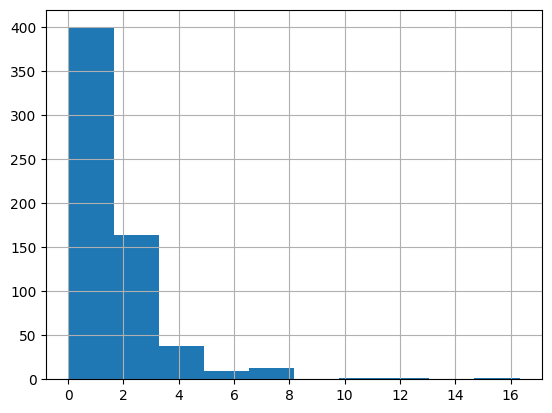

In [20]:
(user_preferences_artist_lyrics.groupby('artist').count() / preference_size_distribution['mean']).mean(axis=1).hist(bins=10)

Including the entire lyrics dataset along with the artist name will bias the similarity calculation, so instead, only the top 5 most frequent words in the lyrics will be included, to allow for artist name to be given a higher weight.

### Histogram of Artist Frequencies in Top N Words in Lyrics + Artist Name + Song Name in Preference Data

Adding in a subset of lyrics along with the artist's name and song name as the terms for each song document seems to give the best distribution. The right-tail is now less sparse and the average # of songs per artist in an individual user's preferences tend to be higher.

This may mean the algorithm to generate synthetic user preference data is now capturing the relationships within an individual artist's library of music and recommending songs that are closer to the artist at each individual random sample.

<Axes: >

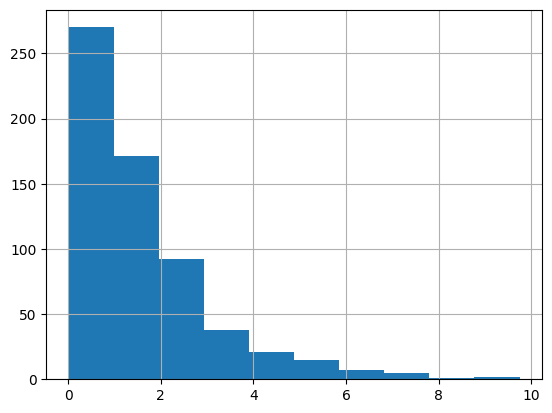

In [43]:
(user_preferences_song_artist_lyrics.groupby('artist').count() / preference_size_distribution['mean']).mean(axis=1).hist(bins=10)

In [21]:
user_lyrics_only_preferences['artist'].apply(lambda x: len(x.split(' '))).mean() # artist name tends to have 1-2 words

1.8051082202534485

In [22]:
user_lyrics_only_preferences['text'].apply(lambda x: len(x.split(' '))).mean() # lyrics tend to have 337! words

337.1851575642032

In [23]:
# lets make a function to select only the top n words in the lyrics
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
def top_n_words(text, n):
  freq_dist = FreqDist(word_tokenize(text))
  # remove filler words
  freq_dist = FreqDist({key: val for key, val in freq_dist.items() if key not in nltk.corpus.stopwords.words('english')})
  # select only the words from the (word, freq) tuple list
  words = ' '.join([word for word, freq in freq_dist.most_common()])
  return words

In [24]:
top_words_lyrics_only = sample_user_lyrics_only['text'].apply(lambda x: top_n_words(x, 5)) # lets try using 5 words

In [25]:
top_words_artist_lyrics = sample_user_preferences_artist_lyrics['text'].apply(lambda x: top_n_words(x, 5)) # lets try using 5 words

In [44]:
top_words_song_artist_lyrics = sample_user_preferences_song_artist_lyrics['text'].apply(lambda x: top_n_words(x, 5)) # lets try using 5 words

In [26]:
# visualization of the sample users top_n words using a word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(top_words_artist_lyrics.iloc[0])

In [27]:
sample_user_artists_lyrics_only = ' '.join(sample_user_lyrics_only['artist'].tolist())

In [28]:
sample_user_artists_artist_lyrics = ' '.join(sample_user_preferences_artist_lyrics['artist'].tolist())

In [45]:
sample_user_artists_song_artist_lyrics = ' '.join(sample_user_preferences_song_artist_lyrics['artist'].tolist())

## Word Clouds of Artist's and Lyrics for Sample Users by Recommendation Type

Intuitively, the distribution of artist frequencies per user shows that user's are now having more songs in their preferences centered around related artists.

We can see that this is the case as the lyric-only recommendations shows the largest variety of artists, where each artist is relatively small.

### Wordcloud of Artists

#### Wordcloud of Artists given Lyric Only Recommendation

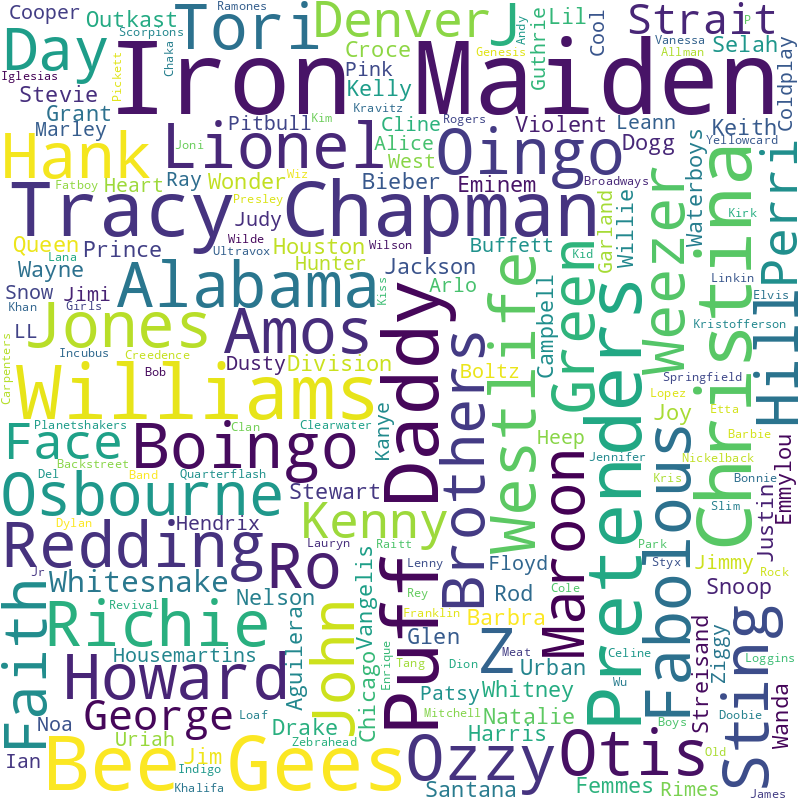

In [29]:
wordcloud.generate(sample_user_artists_lyrics_only).to_image() # word cloud of sample users artist preferences

#### Wordcloud of Artist given Top N Words in Lyric + Artist Name Recommendation

This wordcloud which now shows how recommendations are made when including the artist's name shows shows a smaller variety, and larger size per words than the lyric only recommendation.

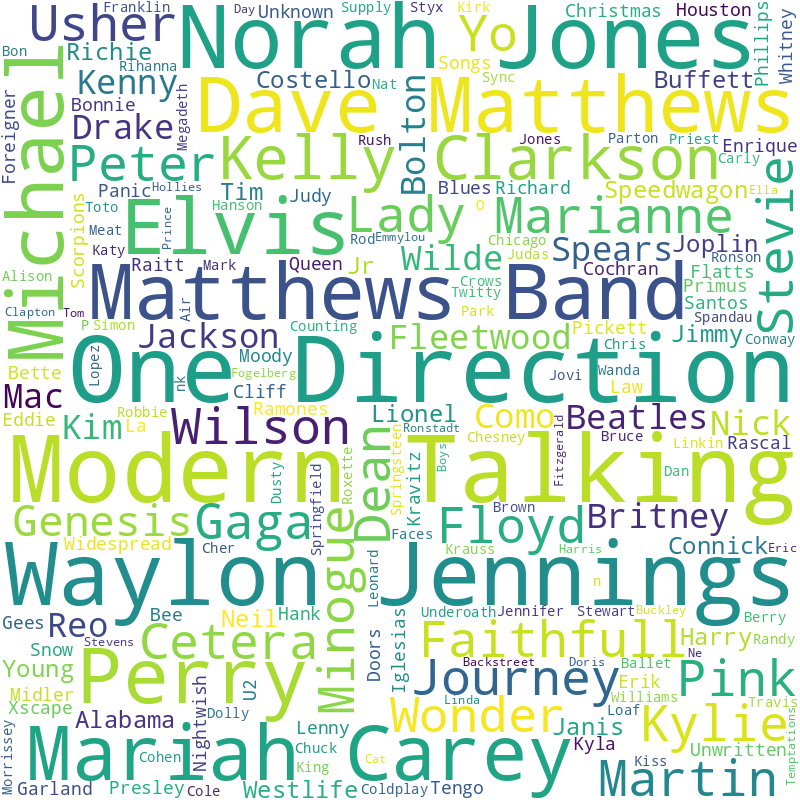

In [30]:
wordcloud.generate(sample_user_artists_artist_lyrics).to_image() # word cloud of sample users artist preferences

#### Wordcloud of Artist given Top N Words in Lyric + Artist Name + Song Name Recommendation


This wordcloud showing the largest input (lyric + artist name + song name) data shows how artist recommendations shows similar artist variety to the artist+lyric cloud, with the exception of having the largest size variety in words/artist names than all previous word clouds, which may make it easier to seperate favorites using a neural network.

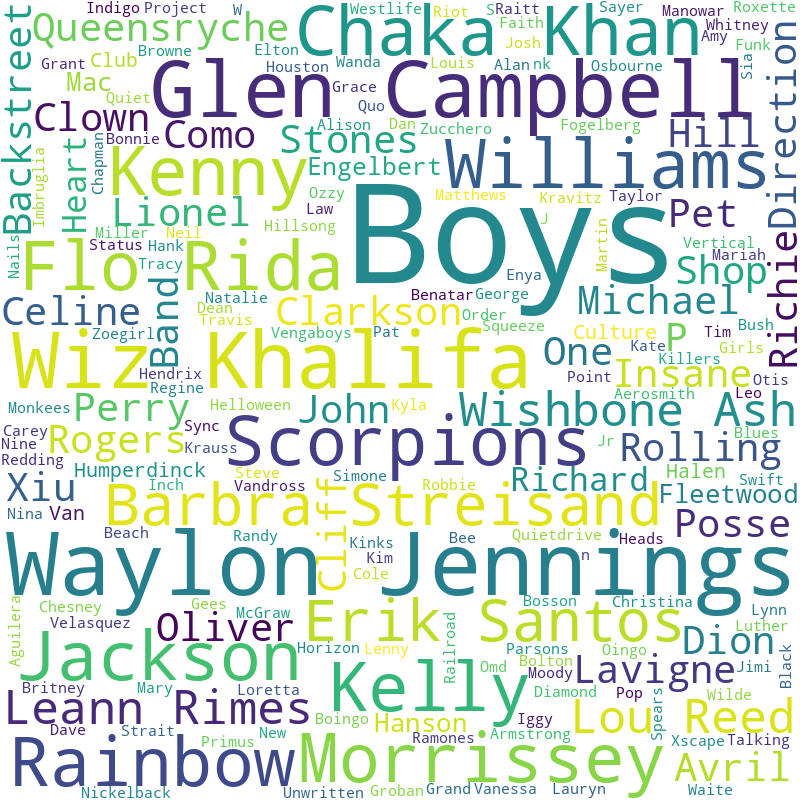

In [46]:
wordcloud.generate(sample_user_artists_song_artist_lyrics).to_image() # word cloud of sample users artist preferences

### Wordcloud of Lyrics

In [31]:
sample_user_words_lyrics_only = ' '.join(top_words_lyrics_only.tolist())

In [32]:
sample_user_words_artist_lyrics = ' '.join(top_words_artist_lyrics.tolist())

In [49]:
sample_user_words_song_artist_lyrics = ' '.join(top_words_song_artist_lyrics.tolist())

#### Wordcloud of Lyrics given Lyric Only Recommendation

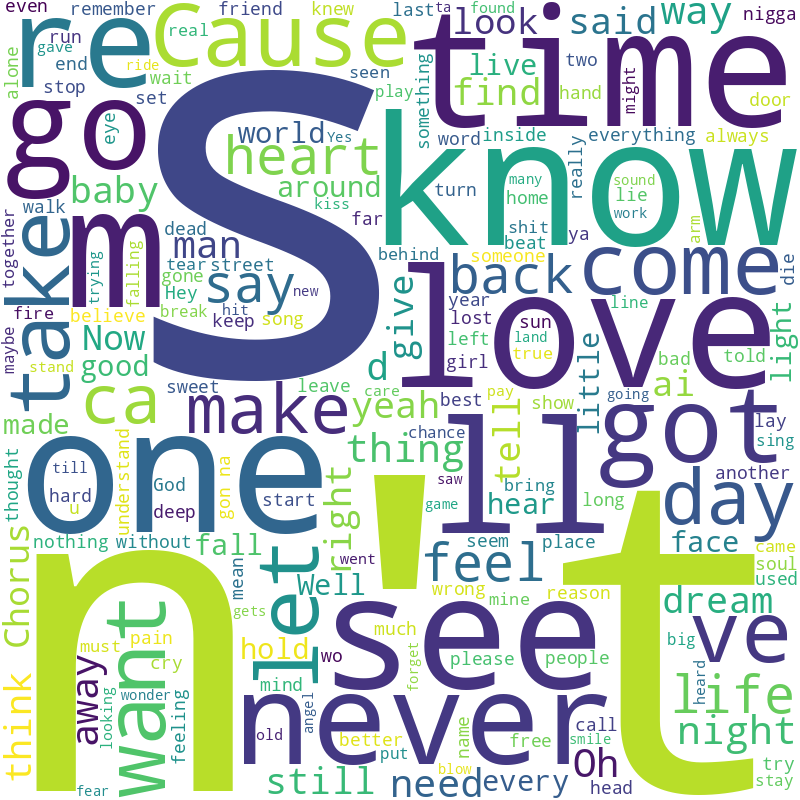

In [33]:
wordcloud.generate(sample_user_words_lyrics_only).to_image() # word cloud of sample user's lyric preferences

#### Wordcloud of Lyrics given Top N Words in Lyric + Artist Name Recommendation

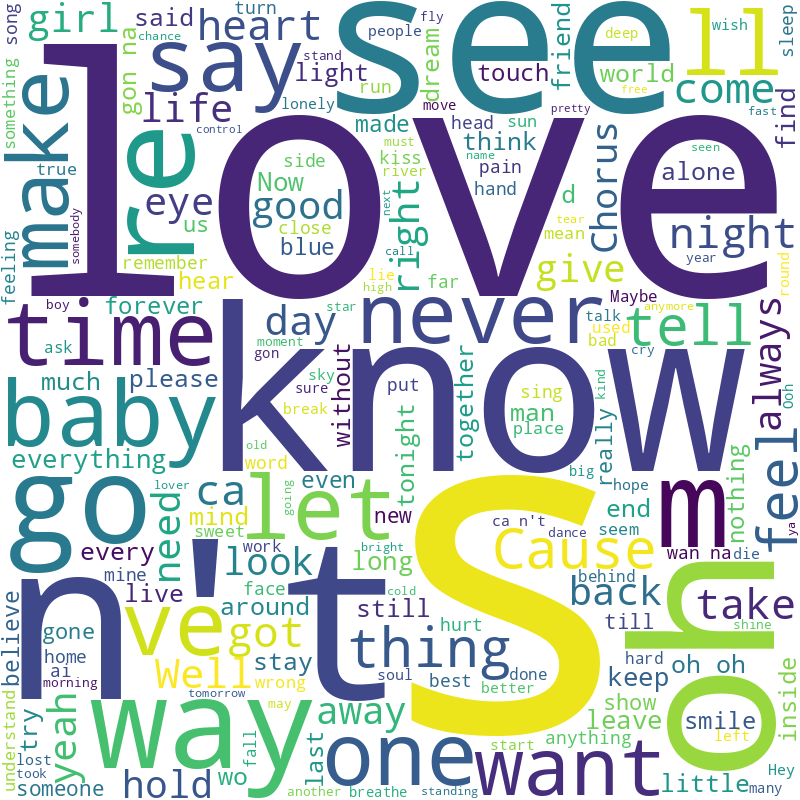

In [34]:
wordcloud.generate(sample_user_words_artist_lyrics).to_image() # word cloud of sample user's lyric preferences

#### Wordcloud of Lyrics given Top N Words in Lyric + Artist Name + Song Name Recommendation

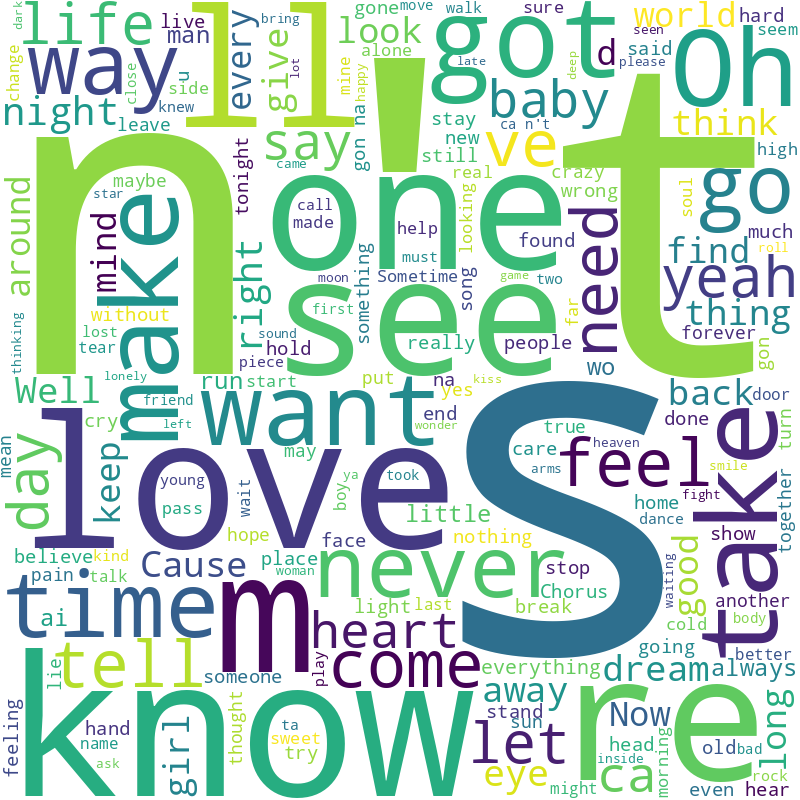

In [50]:
wordcloud.generate(sample_user_words_song_artist_lyrics).to_image() # word cloud of sample user's lyric preferences